Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [156]:
# IMPORTS

from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [128]:
# Load data downloaded from https://srcole.github.io/100burritos/

# Pandas Display Options:
pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns',55)

# WRANGLE DATA

def loadin(f_path):
    # Load in data and include instructor wrangling
    df = pd.read_csv(DATA_PATH+f_path)

    # Derive binary classification target:
    # We define a 'Great' burrito as having an
    # overall rating of 4 or higher, on a 5 point scale.
    # Drop unrated burritos.
    df = df.dropna(subset=['overall'])
    df['Great'] = df['overall'] >= 4

    # Clean/combine the Burrito categories
    df['Burrito'] = df['Burrito'].str.lower()

    california = df['Burrito'].str.contains('california')
    asada = df['Burrito'].str.contains('asada')
    surf = df['Burrito'].str.contains('surf')
    carnitas = df['Burrito'].str.contains('carnitas')

    df.loc[california, 'Burrito'] = 'California'
    df.loc[asada, 'Burrito'] = 'Asada'
    df.loc[surf, 'Burrito'] = 'Surf & Turf'
    df.loc[carnitas, 'Burrito'] = 'Carnitas'

    df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

    # Drop some high cardinality categoricals
    df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

    # Drop some columns to prevent "leakage"
    df = df.drop(columns=['Rec', 'overall'])

    return df

def wrangle(filepath):
    # Execute loadin(filepath)
    df = loadin(filepath)

    # Change 'Date' to_datetime object and set as index
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
    df.set_index(keys='Date', inplace=True)
    df.sort_index(inplace=True)

    # Queso was never selected
    df.drop(labels='Queso', axis=1, inplace=True)

    # Drop other unhelpful columns
    df.drop(labels=['Chips', 'Mass (g)', 'Density (g/mL)', 'Unreliable', 'NonSD'], 
            axis=1, inplace=True)

    return df

burrito_df = wrangle('burritos/burritos.csv')
burrito_df.head()

,Burrito,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-05-16,Other,NaN,NaN,8.00,4.0,NaN,NaN,NaN,3.0,NaN,2.0,3.0,2.0,3.0,2.0,3.0,2.0,x,x,x,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2015-04-20,Other,NaN,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,5.0,5.0,5.0,4.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2016-01-18,California,3.5,4.2,6.49,3.0,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,Asada,NaN,NaN,5.25,2.0,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,California,3.5,3.3,5.45,3.5,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [129]:
burrito_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2011-05-16 to 2026-04-25
Data columns (total 52 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Burrito        421 non-null    object 
 1   Yelp           87 non-null     float64
 2   Google         87 non-null     float64
 3   Cost           414 non-null    float64
 4   Hunger         418 non-null    float64
 5   Length         283 non-null    float64
 6   Circum         281 non-null    float64
 7   Volume         281 non-null    float64
 8   Tortilla       421 non-null    float64
 9   Temp           401 non-null    float64
 10  Meat           407 non-null    float64
 11  Fillings       418 non-null    float64
 12  Meat:filling   412 non-null    float64
 13  Uniformity     419 non-null    float64
 14  Salsa          396 non-null    float64
 15  Synergy        419 non-null    float64
 16  Wrap           418 non-null    float64
 17  Beef           179 non-null    obje

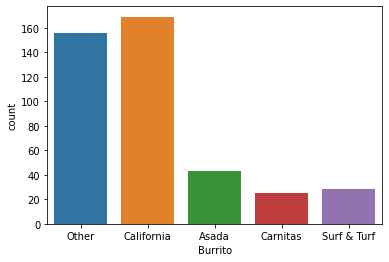

In [189]:
sns.countplot(burrito_df['Burrito']);

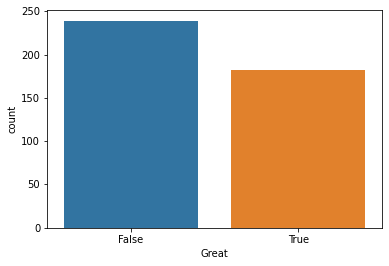

In [190]:
sns.countplot(burrito_df['Great']);

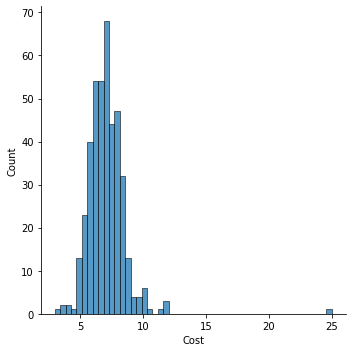

In [192]:
sns.displot(burrito_df['Cost']);

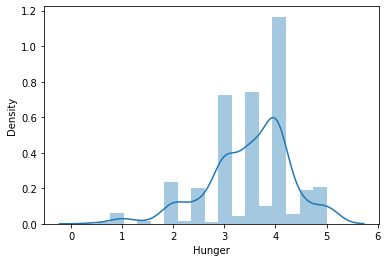

In [194]:
sns.distplot(burrito_df['Hunger']);

In [97]:
# SPLIT THE DATA 
# Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

target = 'Great'

y = burrito_df[target]
X = burrito_df.drop(columns=target)

print(X.shape, y.shape)

(421, 51) (421,)


In [99]:
cutoff_train = X.index.year <= 2016
cutoff_val = X.index.year == 2017
cutoff_test = X.index.year >= 2018

In [104]:
X_train, y_train = X.loc[cutoff_train], y.loc[cutoff_train]
X_val, y_val = X.loc[cutoff_val], y.loc[cutoff_val]
X_test, y_test = X.loc[cutoff_test], y.loc[cutoff_test]

In [123]:
# ESTABLISH A BASELINE ACCURACY SCORE FOR OUR CLASSIFICATION PROBLEM - GREAT / NOT GREAT

baseline_acc = y_train.value_counts(normalize=True, ascending=False)[0]

pd.crosstab(index=y_train, columns='counts', normalize=True).sort_values(by='counts', 
                                                                         ascending=False)

print(f'Baseline Accuracy Score (chance of being correct if we always picked the majority class): {baseline_acc*100:.2f}%')
                                                                    

Baseline Accuracy Score (chance of being correct if we always picked the majority class): 59.06%


In [149]:
model_logr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='most_frequent'),
    StandardScaler(),
    LogisticRegression()
)

model_logr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Burrito', 'Beef', 'Pico', 'Guac',
                                     'Cheese', 'Fries', 'Sour cream', 'Pork',
                                     'Chicken', 'Shrimp', 'Fish', 'Rice',
                                     'Beans', 'Lettuce', 'Tomato', 'Bell peper',
                                     'Carrots', 'Cabbage', 'Sauce', 'Salsa.1',
                                     'Cilantro', 'Onion', 'Taquito',
                                     'Pineapple', 'Ham', 'Chile relleno',
                                     'Nopales', 'Lobster', 'Egg', 'Mushroom', ...],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [150]:
y_pred = model_logr.predict(X_train)

print(f'Baseline Logistic Regression training accuracy score: {model_logr.score(X_train, y_train)*100:.2f}')
print(f'Validation (pass #1) Logistic Regression validation accuracy score: {model_logr.score(X_val, y_val)*100:.2f}')

Baseline Logistic Regression training accuracy score: 93.96
Validation (pass #1) Logistic Regression validation accuarcy score: 77.65


In [154]:
train_scores = []
val_scores = []

for C in np.arange(1, 20, 0.5):
    print('Training model at C value of:', C)

    model_logr = make_pipeline(
        OneHotEncoder(use_cat_names=True),
        SimpleImputer(strategy='most_frequent'),
        StandardScaler(),
        LogisticRegression(C=C)
    )

    model_logr.fit(X_train, y_train)

    train_score = model_logr.score(X_train, y_train)*100
    val_score = model_logr.score(X_val, y_val)*100
    
    print(f'Training Score: {train_score:.2f}')
    print(f'Validation Score: {val_score:.2f} \n\n')
    
    train_scores.append(train_score)
    val_scores.append(val_score)

Training model at C value of: 1.0
Training Score: 93.96
Validation Score: 77.65 


Training model at C value of: 1.5
Training Score: 94.97
Validation Score: 77.65 


Training model at C value of: 2.0
Training Score: 94.97
Validation Score: 77.65 


Training model at C value of: 2.5
Training Score: 94.97
Validation Score: 78.82 


Training model at C value of: 3.0
Training Score: 94.63
Validation Score: 80.00 


Training model at C value of: 3.5
Training Score: 94.63
Validation Score: 80.00 


Training model at C value of: 4.0
Training Score: 94.63
Validation Score: 80.00 


Training model at C value of: 4.5
Training Score: 94.63
Validation Score: 80.00 


Training model at C value of: 5.0
Training Score: 94.63
Validation Score: 81.18 


Training model at C value of: 5.5
Training Score: 94.63
Validation Score: 81.18 


Training model at C value of: 6.0
Training Score: 94.63
Validation Score: 81.18 


Training model at C value of: 6.5
Training Score: 94.63
Validation Score: 81.18 


Trai

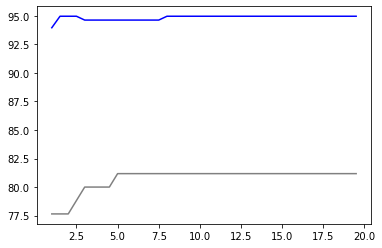

In [159]:
plt.plot(np.arange(1, 20, 0.5), train_scores, color='blue', label='train')
plt.plot(np.arange(1, 20, 0.5), val_scores, color='grey', label='validation')

In [166]:
# Best C value = 5.5 

model_logr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='most_frequent'),
    StandardScaler(),
    LogisticRegression(C=5.5)
)

model_logr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Burrito', 'Beef', 'Pico', 'Guac',
                                     'Cheese', 'Fries', 'Sour cream', 'Pork',
                                     'Chicken', 'Shrimp', 'Fish', 'Rice',
                                     'Beans', 'Lettuce', 'Tomato', 'Bell peper',
                                     'Carrots', 'Cabbage', 'Sauce', 'Salsa.1',
                                     'Cilantro', 'Onion', 'Taquito',
                                     'Pineapple', 'Ham', 'Chile relleno',
                                     'Nopales', 'Lobster', 'Egg', 'Mushroom', ...],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=5.5))])

In [167]:
print(f'Baseline Accuracy Score (chance of being correct if we always picked the majority class): {baseline_acc*100:.2f}%')
print(f'C-tuned Logistic Regression training accuracy score: {model_logr.score(X_train, y_train)*100:.2f}%')
print(f'C-tuned Logistic Regression validation accuracy score: {model_logr.score(X_val, y_val)*100:.2f}%')
print(f'C-tuned Logistic Regression test accuracy score: {model_logr.score(X_test, y_test)*100:.2f}%')

Baseline Accuracy Score (chance of being correct if we always picked the majority class): 59.06%
C-tuned Logistic Regression training accuracy score: 94.63%
C-tuned Logistic Regression validation accuracy score: 81.18%
C-tuned Logistic Regression test accuracy score: 76.32%


<AxesSubplot:title={'center':'Logistic Regression coefficients'}>

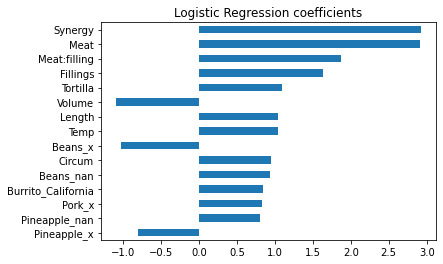

In [184]:
feature_names = model_logr.named_steps['onehotencoder'].get_feature_names()
coefficients = model_logr.named_steps['logisticregression'].coef_[0]

feature_importances = pd.Series(coefficients, index=feature_names).sort_values(key=abs)
feature_importances.tail(15).plot(kind='barh', title='Logistic Regression coefficients')
